Classes found in the dataset:
1. Fan
2. A&C10
3. A&B50
4. A&C30
5. Noload
6. Rotor-0
7. A&C&B30
8. A30
9. A&C&B10
10. A50
11. A10
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3602 - loss: 1.9664
Epoch 1: accuracy improved from -inf to 0.52119, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 576ms/step - accuracy: 0.3781 - loss: 1.9033 - val_accuracy: 0.3390 - val_loss: 1.4526
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7650 - loss: 0.6019
Epoch 2: accuracy improved from 0.52119 to 0.77542, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.7662 - loss: 0.5985 - val_accuracy: 0.4915 - val_loss: 1.0914
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8242 - loss: 0.4294
Epoch 3: accuracy improved from 0.77542 to 0.80508, saving model to mobile_net_classifier.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.8221 - loss: 0.4320 - val_accuracy: 0.6441 - val_

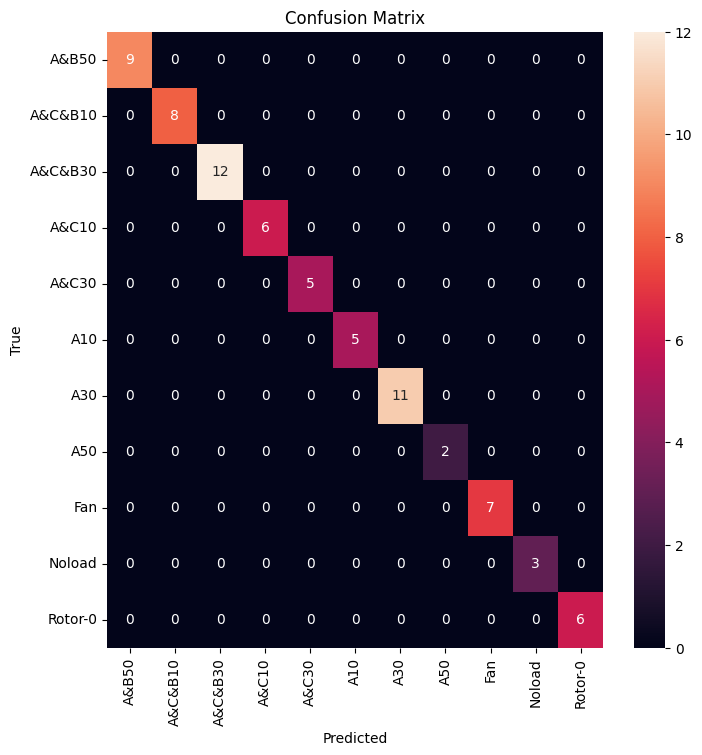

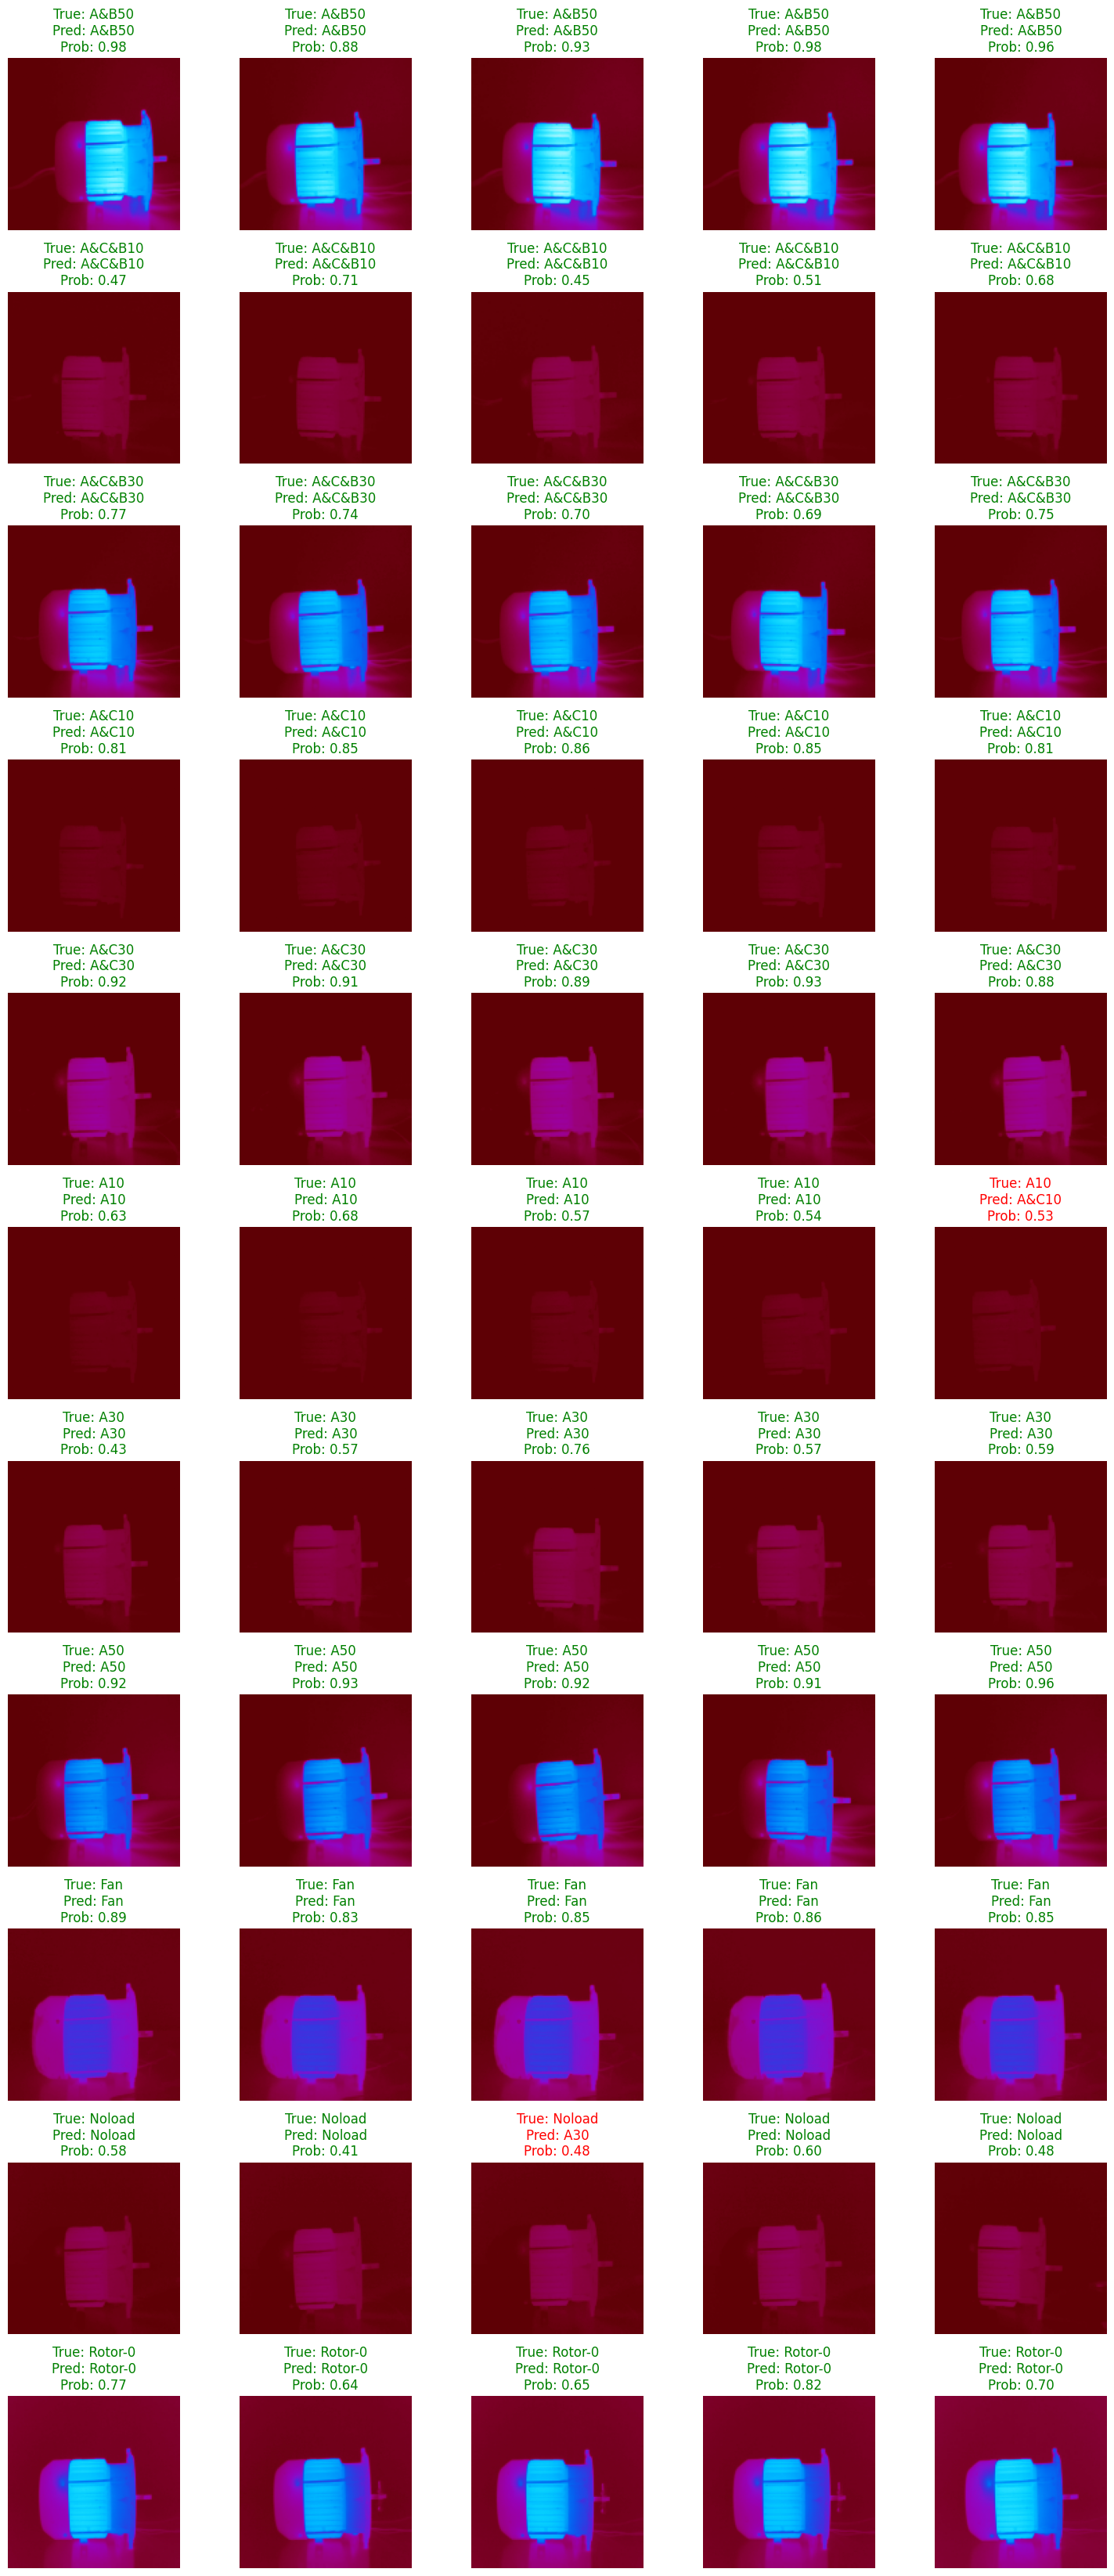

Model saved to /kaggle/working/my_model.h5


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
def load_images_from_folders(base_dir, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_names = [name for name in class_names if name != 'Read me.txt']
    class_mapping = {name: idx for idx, name in enumerate(class_names)}
    
    for folder_name in class_names:
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.bmp'):
                    img_path = os.path.join(folder_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(class_mapping[folder_name])
                    
    return np.array(images), np.array(labels), class_mapping

base_dir = '/kaggle/input/thermal-images-of-induction-motor'
target_size = (128, 128)
images, labels, class_mapping = load_images_from_folders(base_dir, target_size)
images = images.astype('float32') / 255.0
images_train, images_test, classes_train, classes_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

import os

def list_classes(directory):
    """
    List all class names in the given directory. Assumes each class is a subfolder.

    Args:
        directory (str): Path to the directory containing the dataset.

    Returns:
        list: A list of class names (subfolder names).
    """
    try:
        # Get a list of all subdirectories (classes)
        class_names = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
        return class_names
    except Exception as e:
        print(f"Error: {e}")
        return []

# Directory path
dataset_directory = '/kaggle/input/thermal-images-of-induction-motor'

# Get class names
classes = list_classes(dataset_directory)

if classes:
    print("Classes found in the dataset:")
    for idx, class_name in enumerate(classes, 1):
        print(f"{idx}. {class_name}")
else:
    print("No classes found or invalid directory.")
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduced parameters compared to Flatten
    BatchNormalization(),
    Dense(64, activation='relu'),  # Reduced units to 64
    Dropout(0.3),  # Reduced dropout rate
    Dense(len(class_mapping), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary()

checkpoint = ModelCheckpoint(
    'mobile_net_classifier.keras',             
    monitor = 'accuracy',      
    mode = 'max',                  
    save_best_only = True,         
    verbose = 1                    
)

early_stopping = EarlyStopping(
    monitor = 'loss',  
    mode = 'min',              
    patience = 20,             
    verbose = 1                
)

history = model.fit(
    images_train, classes_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 32,
    callbacks = [checkpoint, early_stopping]
)

classes_pred = np.argmax(model.predict(images_test), axis = 1)

print("Classification Report:")
print(classification_report(classes_test, classes_pred, target_names = list(class_mapping.keys())))

cm = confusion_matrix(classes_test, classes_pred)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = class_mapping.keys(), yticklabels = class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

reverse_class_mapping = {v: k for k, v in class_mapping.items()}
num_images = 5

fig, axes = plt.subplots(len(class_mapping), num_images, figsize = (15, len(class_mapping) * 3))


for i, (class_name, class_idx) in enumerate(class_mapping.items()):
    
    class_indices = np.where(labels == class_idx)[0][:num_images]
    
    for j, idx in enumerate(class_indices):
        img = images[idx]
        true_label = reverse_class_mapping[labels[idx]]
    
        img_expanded = np.expand_dims(img, axis = 0)
        prediction = model.predict(img_expanded, verbose = 0)
        predicted_label = reverse_class_mapping[np.argmax(prediction)]
        probability = np.max(prediction)
        
        correct = predicted_label == true_label
        color = 'green' if correct else 'red'
        
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'True: {true_label}\nPred: {predicted_label}\nProb: {probability:.2f}', color=color)
    
plt.tight_layout()
plt.show()

# Save the model to the Kaggle working directory
model.save('/kaggle/working/my_model.h5')

print("Model saved to /kaggle/working/my_model.h5")